# Exercise 05 ANN for Binary Classificatoin - Instruction

## Pedagogy

This notebook serves as an instruction for implementing ANNs using Pytorch to develop binary classification models.

Please use this notebook as a reference and guide to complete the assignment.

### Pre-configure

Some of the new libraries used in this Jupyter Notebook:
- `os` for operating the file system
- `datetime` for obtaining and recording time

In [1]:
# import libraries
import os
import datetime
import warnings

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from torch import nn
from torch.utils.data import TensorDataset, DataLoader

In [2]:
# suppress all warnings
warnings.filterwarnings("ignore")

In [3]:
# get cpu, gpu or mps device for computation
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


## Part 1. Logistic Regression for binary classification

### Step 1. Build the data pipeline

We will use a toy dataset, the breast cancer wisconsin dataset, from `sklearn`. You can find more detials about this dataset at this [link](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html).

As this dataset is a tabular one that consists of numerical feature and target variables. We can use `torch.utils.data.TensorDataset`, a custom class that inherits from the `torch.utils.data.Dataset` class.

In this step, we need to:
1. Use `sklearn.datasets.load_breast_cancer()` to load the dataset
2. Perform feature scaling for the numerical feature variables
3. Divide the dataset into the training, <span style="color:red">validation</span>, and test set
    - We can still use `sklearn.model_selection.train_test_split()`
    - First divide the entire dataset into the _trianing plus validation_ set and the _test_ set
    - Then divide the _trianing plus validation_ set into the _training_ set and the _validation_ set 
5. Create `TensorDataset` instances to store the training, <span style="color:red">validation</span>, and test set
6. Create `DataLoader` instances to wrap the training, <span style="color:red">validation</span>, and test set as iterable objects
    - Set `shuffle = True` for the training data loader
    - Set `shuffle = False` fro the validation and test data loader

In [4]:
# load brease cancer dataset
feature, label = datasets.load_breast_cancer(
    return_X_y = True,
    as_frame = False, # get data as numpy array
)

In [5]:
# feature scaling
scaler = StandardScaler()
scaled_feature = scaler.fit_transform(feature)

In [6]:
# Split the dataset into training, validation, and test sets
train_val_feature, test_feature, train_val_label, test_label = train_test_split(
    scaled_feature, label, test_size = 0.2, random_state = 0
)
train_feature, val_feature, train_label, val_label = train_test_split(
    train_val_feature, train_val_label, test_size = 0.25, random_state = 0
)

- $20\%$ of data is used as the test set
- $80\%\times25\%=20\%$ of data is used as the validation set
- The rest $60\%$ of data is used as the training set

In [7]:
# create the training, validatoin, and test set
# specify the type of data stored in the tensors to avoid incompatiblity
train_ds = TensorDataset(
    torch.tensor(train_feature, dtype = torch.float32),
    torch.tensor(train_label, dtype = torch.float32)
)
val_ds = TensorDataset(
    torch.tensor(val_feature, dtype = torch.float32),
    torch.tensor(val_label, dtype = torch.float32)
)
test_ds = TensorDataset(
    torch.tensor(test_feature, dtype = torch.float32),
    torch.tensor(test_label, dtype = torch.float32)
)

In [8]:
# create the training and test data loaders
batch_size = 64 # usually set to 2 to the nth power
train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle = True)
val_dl = DataLoader(val_ds, batch_size = batch_size, shuffle = False)
test_dl = DataLoader(test_ds, batch_size = batch_size, shuffle = False)

### Step 2. Create the artificial neural network

To define a neural network in `PyTorch`, we create a class that inherits from `torch.nn.Module`.

Use an ANN as a logistic regression model means:
- One-layer network
    - The number of input neurons is equal to the number of input features
    - Only one output neuron which predicts the probabilities
- <span style="color:red">The activation function of the output neuron is `nn.Sigmoid()`</span>

In [9]:
# define a custom neural network class
class LogisticRegressionNet(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_features, 1),
            nn.Sigmoid()
        )
    def forward(self, X):
        return self.net(X)

In [10]:
# create the neural network
model = LogisticRegressionNet(n_features = feature.shape[1])
model.to(device) # move neural network to the computation device

LogisticRegressionNet(
  (net): Sequential(
    (0): Linear(in_features=30, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

### Step 3. Train the network

We define a `train()` function to perform the training process, which takes the following parameters:
- A data loader of the training set
- <span style="color:red">A data loader of the validation set</span>
- A loss function (<span style="color:red">use `nn.BCELoss()` for binary classification</span>)
- An optimizer
    - We also add <span style="color:red">L2 Regularization</span> through the `weight_decay` parameter of the optimizer
    - We implement <span style="color:red">learning rate decay</span> by monitoring the loss on validation set
    - We implement <span style="color:red">early stopping</span> by monitoring the loss on validation set
- The maximum number of epoches to train
- <span style="color:red">The prefix of file name for automatically saving models during the training process</span>

In a single training loop, we need to:
1. Make predictions on the training set (in batch)
2. Compute the loss on the training set (in batch)
3. Update network parameters according to gradients (in batch)
4. <span style="color:red">Make predictions on the validation set (in batch)</span>
5. <span style="color:red">Compute the loss on the validation set (in batch)</span>
6. <span style="color:red">Monitor the changes in the validation loss (in epoch), to:</span>
    - <span style="color:red">Perform leanring rate decay</span>
    - <span style="color:red">Perform early stopping</span>
    - <span style="color:red">Automatically save network when a better validation loss is achieved</span>

At the end of the training process, the `train()` function will return:
- The batch and epoch loss history on the training and validation set
- <span style="color:red">The `saved_path` of the best network for reloading</span>

In [11]:
# define the training function
def train(
    train_dl,
    val_dl,
    model,
    loss_fn,
    optimizer,
    epochs,
    early_stopping_patience,
    lr_scheduler,
    saved_path_prefix
):
    # initialization
    min_val_loss = np.inf # initialize min_val_loss as an infinite positive value
    patience_counter = 0 # set the initial patience_counter to zero
    histories = {
        'train_batch': [],
        'train_epoch': [],
        'val_batch': [],
        'val_epoch': []
    } # aggregate loss histories into a dictionary
    saved_path = '' # create saved_path
    
    # start training
    for epoch in range(epochs):
        # training set
        train_epoch_loss = 0.0
        model.train() # set the model in training mode
        for (X, y) in train_dl:
            X, y = X.to(device), y.to(device)
            prob = model(X).squeeze() # predict probabilities, squeeze() reduce `prob` to 1D tensor
            train_batch_loss = loss_fn(prob, y)
            train_batch_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            histories['train_batch'].append(train_batch_loss.item())
            train_epoch_loss += train_batch_loss.item()
        train_epoch_loss /= len(train_dl)
        histories['train_epoch'].append(train_epoch_loss)
        
        # validation set
        val_epoch_loss = 0.0
        model.eval() # set the model in evaluation mode
        with torch.no_grad():
            for (X, y) in val_dl:
                X, y = X.to(device), y.to(device)
                prob = model(X).squeeze() # predict probabilities, squeeze() reduce `prob` to 1D tensor
                val_batch_loss = loss_fn(prob, y)
                histories['val_batch'].append(val_batch_loss.item())
                val_epoch_loss += val_batch_loss.item()
            val_epoch_loss /= len(val_dl)
            histories['val_epoch'].append(val_epoch_loss)
        
        # print log
        print(f"Epoch {epoch + 1}: train loss = {train_epoch_loss:>5f}, val loss = {val_epoch_loss:>5f}")
        
        # learning rate decay
        current_lr = optimizer.param_groups[0]['lr']
        lr_scheduler.step(val_epoch_loss)
        new_lr = optimizer.param_groups[0]['lr']
        if current_lr != new_lr:
            print(f'Learning rate reduced after epoch {epoch+1}\n')
        
        # early stopping
        if val_epoch_loss < min_val_loss:
            min_val_loss = val_epoch_loss # update the new min_val_loss
            patience_counter = 0 # reset patience_counter to zero
            # save the current model as a new min_val_loss is achieved
            if os.path.exists(saved_path):
                os.remove(saved_path)
            time_str = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
            saved_path = saved_path_prefix + f'_epoch_{epoch+1}_val_loss_{val_epoch_loss:>4f}_{time_str}.pth'
            torch.save(model.state_dict(), saved_path)
            print(f'Model saved after epoch {epoch+1}\n')
        else:
            patience_counter += 1 # increase patience counter by 1
        if patience_counter >= early_stopping_patience:
            print('Early stopping!')
            break
    return histories, saved_path

In [12]:
# define the training hyper-parameters
loss_fn = nn.BCELoss() # binary cross entropy loss
learning_rate = 1e-1 # initial learning rate
weight_decay = 1e-5 # lambda for L2 regularization
optimizer = torch.optim.SGD(
    model.parameters(),
    lr = learning_rate,
    weight_decay = weight_decay # add L2 regularization
)
epochs = 1000000000 # maximum number of epochs to train
early_stopping_patience = 20
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode = 'min',
    factor = 0.1, # each step multiply the learning rate with 0.1
    patience = 5
)
saved_path_prefix = 'logistic_regression_net'

In [13]:
# train the neural network
histories, saved_path = train(
    train_dl,
    val_dl,
    model,
    loss_fn,
    optimizer,
    epochs,
    early_stopping_patience,
    lr_scheduler,
    saved_path_prefix
)

Epoch 1: train loss = 0.502379, val loss = 0.305004
Model saved after epoch 1

Epoch 2: train loss = 0.279682, val loss = 0.223989
Model saved after epoch 2

Epoch 3: train loss = 0.227846, val loss = 0.187338
Model saved after epoch 3

Epoch 4: train loss = 0.194629, val loss = 0.165894
Model saved after epoch 4

Epoch 5: train loss = 0.168618, val loss = 0.151364
Model saved after epoch 5

Epoch 6: train loss = 0.153098, val loss = 0.139487
Model saved after epoch 6

Epoch 7: train loss = 0.143574, val loss = 0.131185
Model saved after epoch 7

Epoch 8: train loss = 0.128476, val loss = 0.123912
Model saved after epoch 8

Epoch 9: train loss = 0.120765, val loss = 0.118166
Model saved after epoch 9

Epoch 10: train loss = 0.119422, val loss = 0.113168
Model saved after epoch 10

Epoch 11: train loss = 0.115500, val loss = 0.109188
Model saved after epoch 11

Epoch 12: train loss = 0.112782, val loss = 0.106513
Model saved after epoch 12

Epoch 13: train loss = 0.112357, val loss = 0.

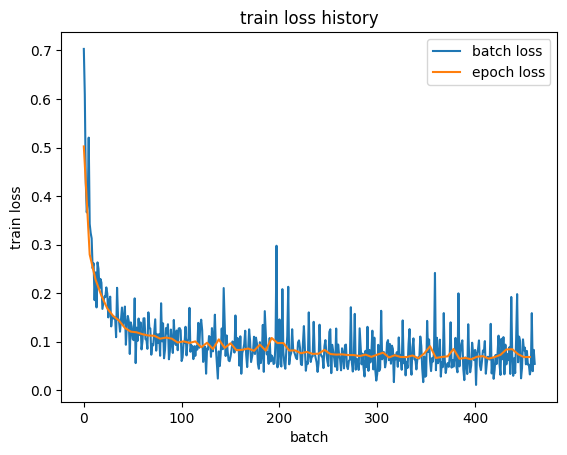

In [14]:
# plot the train loss history
plt.figure()
batch = np.arange(len(histories['train_batch']))
epoch = np.arange(len(histories['train_epoch']))
batches_per_epoch = (int(len(train_ds) / batch_size + 1))
plt.plot(batch, histories['train_batch'], '-', label = 'batch loss')
plt.plot(epoch * batches_per_epoch, histories['train_epoch'], '-', label = 'epoch loss')
plt.title('train loss history')
plt.xlabel('batch')
plt.ylabel('train loss')
plt.legend()
plt.show()

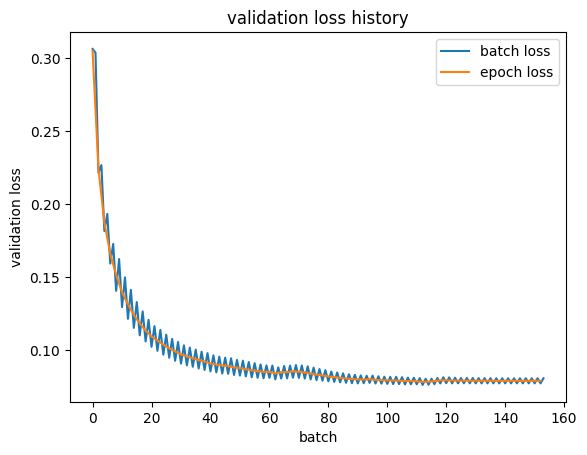

In [15]:
# plot the train loss history
plt.figure()
batch = np.arange(len(histories['val_batch']))
epoch = np.arange(len(histories['val_epoch']))
batches_per_epoch = (int(len(val_ds) / batch_size + 1))
plt.plot(batch, histories['val_batch'], '-', label = 'batch loss')
plt.plot(epoch * batches_per_epoch, histories['val_epoch'], '-', label = 'epoch loss')
plt.title('validation loss history')
plt.xlabel('batch')
plt.ylabel('validation loss')
plt.legend()
plt.show()

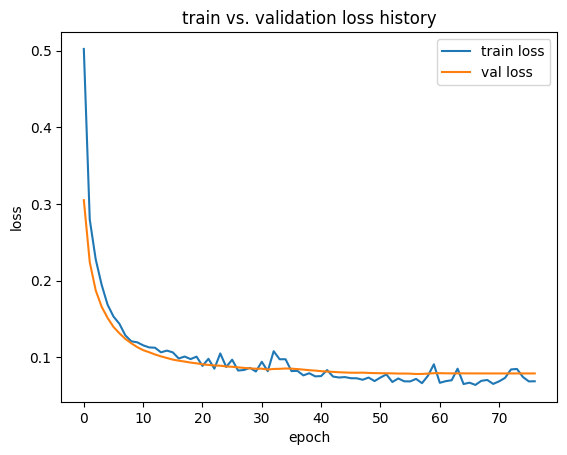

In [16]:
# plot the train vs. val loss history
plt.figure()
plt.plot(np.arange(len(histories['train_epoch'])), histories['train_epoch'], '-', label = 'train loss')
plt.plot(np.arange(len(histories['val_epoch'])), histories['val_epoch'], '-', label = 'val loss')
plt.title('train vs. validation loss history')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

### Step 4. Reload the best model

<span style="color:red">The final model after training may not be the best one saved during the traing process.</span>

<span style="color:red">To use the best model, we need to reload it from the saved file.</span>

In [17]:
# load model
model = LogisticRegressionNet(n_features = feature.shape[1])
model.load_state_dict(torch.load(saved_path))
model.to(device)

LogisticRegressionNet(
  (net): Sequential(
    (0): Linear(in_features=30, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

### Step 5. Make predictions and evaluation

Make predictions on the test set and evaluate the performance of the network.

To do that in batch, we can define a `test()` function, which is similar to the `train` function but much simpler.

Note that, <span style="color:red">the output of the logistic regression network is the probabilities belongs to the positive class. We need to convert the probabilities to categorical predictions by a threshold.</span> Then we can use the classification metrics to evaluate the performance.

In [31]:
# define a function to make predictions on test dataset and evaluate the performance
def test(dataloader, model, loss_fn):
    batch_prob_list = []
    model.eval() # set the model in evaluation mode
    with torch.no_grad(): # disable automatic gradient computing
        loss = 0.0
        for (X, y) in dataloader:
            X, y = X.to(device), y.to(device)
            batch_prob = model(X).squeeze() # predict probabilities, squeeze() reduce `batch_prob` to 1D tensor
            batch_loss = loss_fn(batch_prob, y)
            loss += batch_loss.item()
            batch_prob_list.append(batch_prob.cpu().numpy())
        loss /= len(dataloader)
        prob = np.concatenate(batch_prob_list) # reform the predictions as a numpy 1D array
        print(f"test loss = {loss}") # print log
    return prob, loss

In [19]:
# make prediction on test set and evaluate the performance
test_prob, test_loss = test(test_dl, model, loss_fn)
test_pred = (test_prob > 0.5) # convert the probability to predicted class by a threshold
classes = ['WDBC-Malignant', 'WDBC-Benign']
print(classification_report(test_label, test_pred, target_names = classes))

test loss = 0.09988510981202126
                precision    recall  f1-score   support

WDBC-Malignant       0.96      0.94      0.95        47
   WDBC-Benign       0.96      0.97      0.96        67

      accuracy                           0.96       114
     macro avg       0.96      0.95      0.95       114
  weighted avg       0.96      0.96      0.96       114



## Part 2. Multi-layer ANN for binary classification

Instead of using an one-layer ANN that behaves like a logistic regression model, we can also define a multi-layer ANN as a binary classifer with more capacity.

For example, we can define a deeper and more complex ANN as follows:

In [84]:
# define a custom neural network class
class BinaryClassificationNet(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_features, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 4),
            nn.ReLU(),
            nn.Linear(4, 1),
            nn.Sigmoid()
        )
    def forward(self, X):
        return self.net(X)

In [85]:
# create the neural network
model = BinaryClassificationNet(n_features = feature.shape[1])
model.to(device)

BinaryClassificationNet(
  (net): Sequential(
    (0): Linear(in_features=30, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
    (5): ReLU()
    (6): Linear(in_features=4, out_features=1, bias=True)
    (7): Sigmoid()
  )
)

<span style="color:red">Now let's train a binary classifier using the above defined neural network structure, or define your own network structure, to see if you can improve the performance.</span>
- You can change the following options to see the effects on the training process:
    - batch size
    - number of layers and neurons
    - activation functions
    - lambda of L2 regularization
    - early stopping patience
    - learning rate decay patience

In [86]:
# define the training hyper-parameters
loss_fn = nn.BCELoss() # binary cross entropy loss
learning_rate = 1e-3 # initial learning rate
weight_decay = 1e-5 # lambda for L2 regularization
optimizer = torch.optim.SGD(
    model.parameters(),
    lr = learning_rate,
    weight_decay = weight_decay # add L2 regularization
)
epochs = 1000000000 # maximum number of epochs to train
early_stopping_patience = 20
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode = 'min',
    factor = 0.1, # each step multiply the learning rate with 0.1
    patience = 5
)
saved_path_prefix = 'logistic_regression_net'

In [87]:
# train the neural network
histories, saved_path = train(
    train_dl,
    val_dl,
    model,
    loss_fn,
    optimizer,
    epochs,
    early_stopping_patience,
    lr_scheduler,
    saved_path_prefix
)

Epoch 1: train loss = 0.670571, val loss = 0.677187
Model saved after epoch 1

Epoch 2: train loss = 0.673595, val loss = 0.677100
Model saved after epoch 2

Epoch 3: train loss = 0.672011, val loss = 0.677008
Model saved after epoch 3

Epoch 4: train loss = 0.670152, val loss = 0.676913
Model saved after epoch 4

Epoch 5: train loss = 0.672722, val loss = 0.676825
Model saved after epoch 5

Epoch 6: train loss = 0.670726, val loss = 0.676733
Model saved after epoch 6

Epoch 7: train loss = 0.670001, val loss = 0.676640
Model saved after epoch 7

Epoch 8: train loss = 0.671092, val loss = 0.676551
Model saved after epoch 8

Epoch 9: train loss = 0.671197, val loss = 0.676467
Model saved after epoch 9

Epoch 10: train loss = 0.669430, val loss = 0.676375
Model saved after epoch 10

Epoch 11: train loss = 0.671085, val loss = 0.676289
Model saved after epoch 11

Epoch 12: train loss = 0.669399, val loss = 0.676198
Model saved after epoch 12

Epoch 13: train loss = 0.674141, val loss = 0.

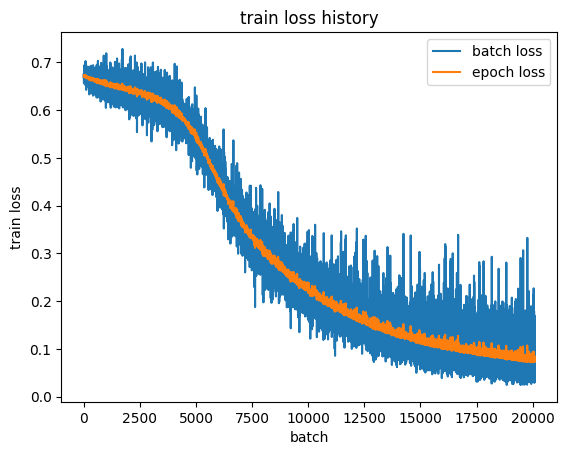

In [88]:
# plot the train loss history
plt.figure()
batch = np.arange(len(histories['train_batch']))
epoch = np.arange(len(histories['train_epoch']))
batches_per_epoch = (int(len(train_ds) / batch_size + 1))
plt.plot(batch, histories['train_batch'], '-', label = 'batch loss')
plt.plot(epoch * batches_per_epoch, histories['train_epoch'], '-', label = 'epoch loss')
plt.title('train loss history')
plt.xlabel('batch')

plt.ylabel('train loss')
plt.legend()
plt.show()

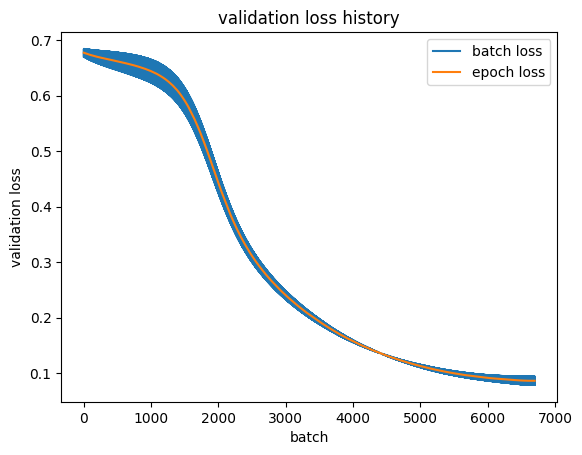

In [89]:
# plot the validation loss history
plt.figure()
batch = np.arange(len(histories['val_batch']))
epoch = np.arange(len(histories['val_epoch']))
batches_per_epoch = (int(len(val_ds) / batch_size + 1))
plt.plot(batch, histories['val_batch'], '-', label = 'batch loss')
plt.plot(epoch * batches_per_epoch, histories['val_epoch'], '-', label = 'epoch loss')
plt.title('validation loss history')
plt.xlabel('batch')
plt.ylabel('validation loss')
plt.legend()
plt.show()

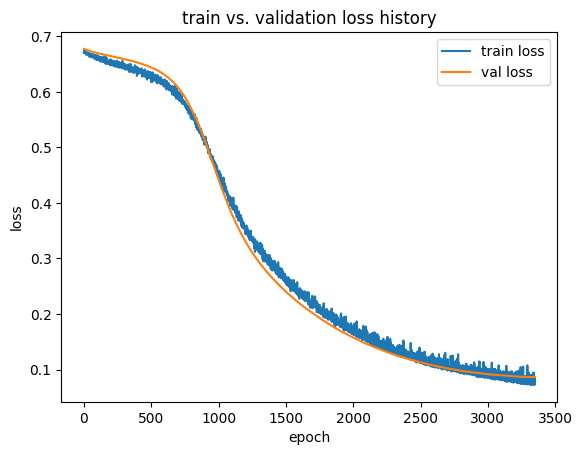

In [90]:
# plot the train vs. val loss history
plt.figure()
plt.plot(np.arange(len(histories['train_epoch'])), histories['train_epoch'], '-', label = 'train loss')
plt.plot(np.arange(len(histories['val_epoch'])), histories['val_epoch'], '-', label = 'val loss')
plt.title('train vs. validation loss history')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [82]:
# load model
model = BinaryClassificationNet(n_features = feature.shape[1])
model.load_state_dict(torch.load(saved_path))
model.to(device)

BinaryClassificationNet(
  (net): Sequential(
    (0): Linear(in_features=30, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
    (5): ReLU()
    (6): Linear(in_features=4, out_features=1, bias=True)
    (7): Sigmoid()
  )
)

In [91]:
# make prediction on test set and evaluate the performance
test_prob, test_loss = test(test_dl, model, loss_fn)
test_pred = (test_prob > 0.5) # convert the probability to predicted class by a threshold
classes = ['WDBC-Malignant', 'WDBC-Benign']
print(classification_report(test_label, test_pred, target_names = classes))

test loss = 0.08029564842581749
                precision    recall  f1-score   support

WDBC-Malignant       0.98      0.96      0.97        47
   WDBC-Benign       0.97      0.99      0.98        67

      accuracy                           0.97       114
     macro avg       0.97      0.97      0.97       114
  weighted avg       0.97      0.97      0.97       114

